# Install dependencies
```shell
sudo apt update
sudo apt upgrade
sudo apt install python3 python3-pip

pip install numpy
pip install pandas
pip install sklearn
pip install xgboost
```

# Init Libraries and Dataset

In [1]:
import numpy as np
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
# from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc


testSet = pd.read_csv('test.csv')
trainSet = pd.read_csv('train.csv')

# Prelim Transformations
This section aims to convert all columns with multiple string values into multiple columns with a single string value
This section then aims to convert the string values of the solution column into proper numbers (1 or 0)

## Break text columns into binary columns

In [2]:
# For every text column, break into multiple binary columns
testSet_transformed = testSet
for col in testSet.axes[1]:
    if testSet[col].dtype == 'object' and col != 'satisfaction':
        testSet_transformed = pd.get_dummies(testSet_transformed, prefix=[col], columns=[col])

trainSet_transformed = trainSet
for col in trainSet.axes[1]:
    if trainSet[col].dtype == 'object' and col != 'satisfaction':
        trainSet_transformed = pd.get_dummies(trainSet_transformed, prefix=[col], columns=[col])

## drop the not necessary columns

In [3]:
testSet_transformed = testSet_transformed.drop("Unnamed: 0", axis=1)
testSet_transformed = testSet_transformed.drop("id", axis=1)

trainSet_transformed = trainSet_transformed.drop("Unnamed: 0", axis=1)
trainSet_transformed = trainSet_transformed.drop("id", axis=1)

# testSet_transformed

## Transform Satisfaction axes
- move satisfaction to last axes
- convert the strings of satisfied or dissatisfied into binary 1 or 0 respectfully

In [4]:
# Reorganize the data such that the solution axes is last
solutionAxes = ['satisfaction']
testSet_transformed = testSet_transformed[
    [col for col in testSet_transformed if col not in solutionAxes] + 
    [col for col in solutionAxes if col in testSet_transformed]
]
trainSet_transformed = trainSet_transformed[
    [col for col in trainSet_transformed if col not in solutionAxes] + 
    [col for col in solutionAxes if col in trainSet_transformed]
]

# Replace solutionAxes values of 'satisfied' or 'neutral or dissatisfied' with 1 or 0 respectively
testSet_transformed['satisfaction'] = testSet_transformed['satisfaction'].replace(['satisfied', 'neutral or dissatisfied'], [1, 0])
trainSet_transformed['satisfaction'] = trainSet_transformed['satisfaction'].replace(['satisfied', 'neutral or dissatisfied'], [1, 0])

## Standardize the missing data

In [5]:
# replace all nan values with 0's
trainSet_nan_col = trainSet_transformed.isna().any()
for i in trainSet_nan_col.keys():
    if trainSet_nan_col[i] == True: 
        # print("Replacing ", i, " NaN Values with ", testSet_transformed[i].mean())
        testSet_transformed[i] = testSet_transformed[i].replace(np.nan, testSet_transformed[i].mean())

testSet_nan_col = trainSet_transformed.isna().any()
for i in testSet_nan_col.keys():
    if testSet_nan_col[i] == True: 
        # print("Replacing ", i, " NaN Values with ", testSet_transformed[i].mean())
        trainSet_transformed[i] = trainSet_transformed[i].replace(np.nan, trainSet_transformed[i].mean())

trainSet_transformed

,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,...,Gender_Female,Gender_Male,Customer Type_Loyal Customer,Customer Type_disloyal Customer,Type of Travel_Business travel,Type of Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus,satisfaction
0,13,460,3,4,3,1,5,3,5,5,...,0,1,1,0,0,1,0,0,1,0
1,25,235,3,2,3,3,1,3,1,1,...,0,1,0,1,1,0,1,0,0,0
2,26,1142,2,2,2,2,5,5,5,5,...,1,0,1,0,1,0,1,0,0,1
3,25,562,2,5,5,5,2,2,2,2,...,1,0,1,0,1,0,1,0,0,0
4,61,214,3,3,3,3,4,5,5,3,...,0,1,1,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103899,23,192,2,1,2,3,2,2,2,2,...,1,0,0,1,1,0,0,1,0,0
103900,49,2347,4,4,4,4,2,4,5,5,...,0,1,1,0,1,0,1,0,0,1
103901,30,1995,1,1,1,3,4,1,5,4,...,0,1,0,1,1,0,1,0,0,0
103902,22,1000,1,1,1,5,1,1,1,1,...,1,0,0,1,1,0,0,1,0,0


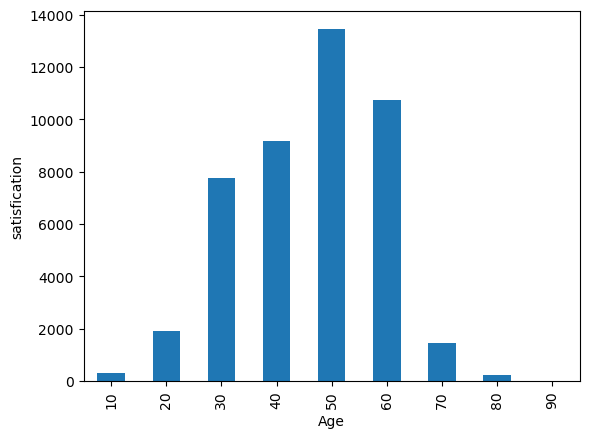

In [118]:
ages = trainSet_transformed["Age"]
Age_groups = pd.cut(ages,  bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90], labels=[10, 20, 30, 40, 50, 60, 70, 80, 90])
grouped = trainSet_transformed.groupby(Age_groups)
grouped= grouped['satisfaction'].agg(lambda x: sum(x))
grouped.plot.bar(x='Age')
plt.ylabel("satisfication")
plt.show()

In [7]:
 #trainSet_transformed.plot.scatter(x="satisfaction", y="Age", s = 100)
 #trainSet_transformed.plot.scatter(x="satisfaction", y="Flight Distance",)

# Split the data into test and train sets

In [8]:
# Load the test and train data
testData = testSet_transformed[testSet_transformed.axes[1][2:-1]]
testSolution = testSet_transformed[testSet_transformed.axes[1][-1]]
trainData = trainSet_transformed[trainSet_transformed.axes[1][2:-1]]
trainSolution = trainSet_transformed[trainSet_transformed.axes[1][-1]]

In [9]:
testData

,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,...,Arrival Delay in Minutes,Gender_Female,Gender_Male,Customer Type_Loyal Customer,Customer Type_disloyal Customer,Type of Travel_Business travel,Type of Travel_Personal Travel,Class_Business,Class_Eco,Class_Eco Plus
0,5,4,3,4,3,4,3,5,5,5,...,44.0,1,0,1,0,1,0,0,1,0
1,1,1,3,1,5,4,5,4,4,4,...,0.0,1,0,1,0,1,0,1,0,0
2,2,0,2,4,2,2,2,2,4,1,...,0.0,0,1,0,1,1,0,0,1,0
3,0,0,0,2,3,4,4,1,1,1,...,6.0,0,1,1,0,1,0,1,0,0
4,2,3,4,3,4,1,2,2,2,2,...,20.0,1,0,1,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25971,3,3,3,1,4,3,4,4,3,2,...,0.0,0,1,0,1,1,0,1,0,0
25972,4,4,4,4,4,4,4,4,4,5,...,0.0,0,1,1,0,1,0,1,0,0
25973,2,5,1,5,2,1,2,2,4,3,...,0.0,1,0,1,0,0,1,0,1,0
25974,3,3,3,3,4,4,4,4,3,2,...,0.0,0,1,1,0,1,0,1,0,0


# AI's

In [10]:
aiScores = []

## KNN Classification

In [11]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(trainData, trainSolution)

testPredict = knn.predict(testData)
accuracy = accuracy_score(testSolution,testPredict)
aiScores.append({"Name":"KNN", "Score":accuracy})


# Decision Tree Classification

In [12]:
## Decision Tree
my_DecisionTree = DecisionTreeClassifier(random_state=3)
my_DecisionTree.fit(trainData, trainSolution)
decisionTreePredict = my_DecisionTree.predict(testData)
decisionTreeAccuracy = accuracy_score(testSolution, decisionTreePredict)
aiScores.append({"Name":"Decision Tree", "Score":decisionTreeAccuracy})

# Random Forest Classifier

In [13]:
## Random Forest
my_RandomForest = RandomForestClassifier(n_estimators=32, bootstrap=True, random_state=1)
my_RandomForest.fit(trainData, trainSolution)

randomForestPredict = my_RandomForest.predict(testData)
randomForestAccuracy = accuracy_score(testSolution, randomForestPredict)
aiScores.append({"Name":"Random Forest", "Score":randomForestAccuracy })

# XGBoost Classifier

In [14]:
## XGBoost
xgb = XGBClassifier()
xgb.fit(trainData, trainSolution)
xgbPredict = xgb.predict(testData)
xgbAccuracy = accuracy_score(testSolution, xgbPredict)
aiScores.append({"Name":"XGBoost", "Score":xgbAccuracy })

In [15]:
accuracyScores = pd.json_normalize(aiScores)
print("Accuracy Scores")
accuracyScores

AttributeError: module 'pandas' has no attribute 'json_normalize'

# Classifier Roc Curve and AUC Score comparison

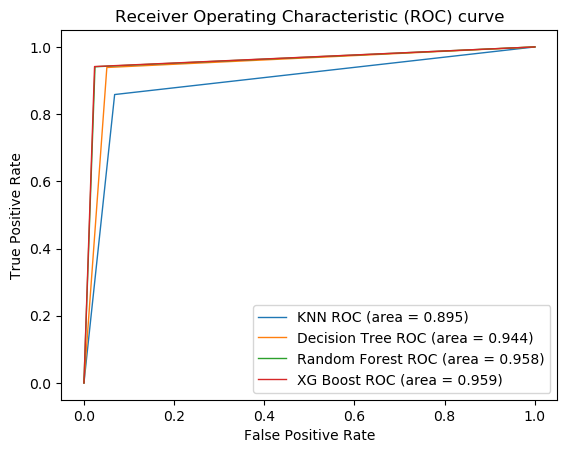

In [ ]:

knn_fpr, knn_tpr, knn_thresholds = roc_curve(testSolution, testPredict)
knn_roc_auc = auc(knn_fpr, knn_tpr)

dt_fpr, dt_tpr, dt_thresholds = roc_curve(testSolution, decisionTreePredict)
dt_roc_auc = auc(dt_fpr, dt_tpr)

rf_fpr, rf_tpr, rf_thresholds = roc_curve(testSolution, randomForestPredict)
rf_roc_auc = auc(rf_fpr, rf_tpr)

xg_fpr, xg_tpr, xg_thresholds = roc_curve(testSolution, xgbPredict)
xg_roc_auc = auc(xg_fpr, xg_tpr)

plt.plot(knn_fpr, knn_tpr, lw=1, label='KNN ROC (area = %0.3f)' % (knn_roc_auc))
plt.plot(dt_fpr, dt_tpr, lw=1, label='Decision Tree ROC (area = %0.3f)' % (dt_roc_auc))
plt.plot(rf_fpr, rf_tpr, lw=1, label='Random Forest ROC (area = %0.3f)' % (rf_roc_auc))
plt.plot(xg_fpr, xg_tpr, lw=1, label='XG Boost ROC (area = %0.3f)' % (xg_roc_auc))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()